In [417]:
cd /Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo/

/Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo


In [3]:
import miniSAFE as ms
import numpy as np
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec as gs
import networkx as nx
from matplotlib.collections import LineCollection
import OMEGA_core as om
from scipy import stats
import seaborn as sns
import tifffile
import os,glob
from skimage.filters import gaussian

In [507]:
# load dataframe
# load dataframe
df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')

# load data
dest_folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/NMF_output/'
reshaped = np.load(dest_folder+'NMF_regrouped.npy')
h = np.load(dest_folder+'NMF_basis.npy')
w = np.load(dest_folder+'NMF_encoding.npy')
snf_data = pk.load(open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SNF_output/SNF_output.pk','rb'))
n_components = 20
positions = snf_data['positions']
g = snf_data['network']
pos = snf_data['embedding']
graph = snf_data['composite_graph']
func_tab = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/func_annot.xlsx',index_col='Functional_category')



safe_dict = pk.load(open( "/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SAFE/SAFE_dict.pk", "rb" ))
gematria_input = np.load('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/packed_rep1_spikein.npy')
gematria_input_filtered = gematria_input[df['Original_index'].values]
graph_data = snf_data['composite_graph']

# map entry ids of the original and selected entries
SAFE_entry_id = df.index[df['SAFE_input']==1].values

In [509]:
def read_tl_data(tl_excel):
    raw_d = pd.read_excel(tl_excel,header=None).values
    norm_y = []
    data_dict = {}
    n=100
    for i in np.arange(0,raw_d.shape[1],2):
        x=raw_d[:,i][np.isnan(raw_d[:,i])==0]
        y=raw_d[:,i+1][np.isnan(raw_d[:,i+1])==0]
        l=x.max()
        interp = np.interp(np.linspace(0,1,100),xp=x/x.max(),fp=y)
        data_dict[int(i/2)]=[l,x,y,interp]
        norm_y.append(interp)
    return np.array(norm_y),data_dict

def merge_tl_data(folder):
    merged_dict={}
    for f in sorted(glob.glob(folder+'*.xlsx')):
        header = f.split('/')[-1].split('.')[0]
        norm_y, data_dict = read_tl_data(f)
        for k,v in data_dict.items():
            merged_dict[header+'_'+str(k)]=v
    return merged_dict

def generate_demograph(merged_dict,max_l=12,xpixels = 512,normalize=False):
    lengths = []
    tiles = []
    for k,v in merged_dict.items():
        l,x,y,interp=v
        if normalize:
            y = (y-y.min())/(y.max()-y.min())
        lengths.append(l)
        if l>max_l:
            tiles.append(np.interp(np.linspace(0,1,xpixels),xp=x/x.max(),fp=y))
        else:
            half_l = int(round(0.5*l*xpixels/max_l))
            pad = int((xpixels-half_l*2)/2)
            tiles.append(np.array([0]*pad+list(np.interp(np.linspace(0,1,half_l*2),xp=x/x.max(),fp=y))+[0]*pad))
    return np.sort(lengths), np.array(tiles)[np.argsort(lengths)]

def length_normalized_dynamics(merged_dict,normalize=False,flip=False,shape=(10,30)):
    from skimage.transform import resize
    lengths = []
    tiles = []
    strain_dict = {}
    averaged = []
    for k,v in merged_dict.items():
        header= '_'.join(k.split('_')[:2])
        if header not in strain_dict:
            strain_dict[header]=[]
        l,x,y,interp=v
        if normalize:
            interp=mean_norm(interp)
        strain_dict[header].append(interp)
    #tiles = np.array(tiles)[np.argsort(lengths)]
    #tiles = resize(tiles,(20,50))
    for strain, val in strain_dict.items():
        resized = resize(np.array(val),shape,anti_aliasing=True)
        if flip:
            resized = np.flip(resized,axis=1)
        averaged.append(resized)
    return strain_dict,averaged

def normalize1d(data):
    return (data-data.min())/(data.max()-data.min())

def mean_norm(data):
    return data/data.mean()

def min_max_normalization(data, pad=0.01):
    # Min-max normalization function
    # constrain zero entries by padding the data with a 0.01 background
    return ((data-data.min())/(data.max()-data.min())+pad)/(1+pad)

def moving_window_1d(data):
    data1 = np.concatenate([data[:1],data[:-1]])
    data2 = np.concatenate([data[1:],data[-1:]])
    return (data1+data2+data)/3

In [512]:
# create demograph for MSMEG_4263
k = df[df['locus']=='MSMEG_4263']['key'].values[0]
data = pk.load(open('/Volumes/Junhao_data_Rubin_Lab/MSR_submission1_archive_202103/MSR_update_20201118/{}/{}_miscellaneous_data.pk'.format(k,k),'rb'))
included = np.where(data['is_outlier']==0)[0]
l = data['lengths']
demograph = data['FITC']['padded_axial_data'][included][np.argsort(l[included])]
fig=plt.figure(figsize=(5,3))
ax=fig.add_subplot()
ax.imshow(demograph.T,aspect='auto')
ax.set_xticks([])
ax.set_yticks([0,127,255,383,511])
ax.set_yticklabels([6,3,0,3,6])
ax.set_ylabel('distance from center [μm]',fontsize=14)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/MSMEG_4263_demograph.png',bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Junhao_data_Rubin_Lab/MSR_submission1_archive_202103/MSR_update_20201118/MSR_08_B06_MSMEG_4263/MSR_08_B06_MSMEG_4263_miscellaneous_data.pk'

In [346]:
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4263/'.format(t)),normalize=True,flip=False)

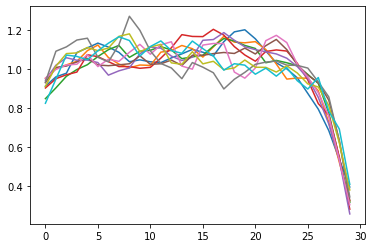

In [358]:
plt.plot(averaged[8].T)

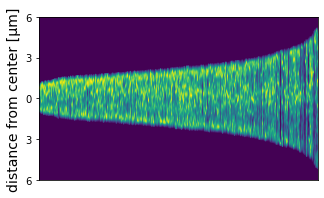

In [24]:
# create demograph for MSMEG_4263
k = df[df['locus']=='MSMEG_4479']['key'].values[0]
data = pk.load(open('/Volumes/Junhao_data_Rubin_Lab/MSR_submission1_archive_202103/MSR_update_20201118/{}/{}_miscellaneous_data.pk'.format(k,k),'rb'))
included = np.where(data['is_outlier']==0)[0]
l = data['lengths']
demograph = data['FITC']['padded_axial_data'][included][np.argsort(l[included])]
fig=plt.figure(figsize=(5,3))
ax=fig.add_subplot()
ax.imshow(demograph.T,aspect='auto')
ax.set_xticks([])
ax.set_yticks([0,127,255,383,511])
ax.set_yticklabels([6,3,0,3,6])
ax.set_ylabel('distance from center [μm]',fontsize=14)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/MSMEG_4479_demograph.png',bbox_inches='tight')

In [550]:
targets = ['MSMEG_3178','MSMEG_1622','MSMEG_4222','MSMEG_4228','MSMEG_0250','MSMEG_0389','MSMEG_5082','MSMEG_6285','MSMEG_1364','MSMEG_6928']
#targets = ['MSMEG_6928']

for t in targets:
    strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(t)),normalize=True,flip=False)
    name = df[df['locus']==t]['name'].values[0]
    if name == t:
        label = t
    else:
        name = name[0].capitalize()+name[1:].split('-')[0]
        label = '{} | {}'.format(t,name)
    midcell_data = []
    whole_cell_data = []
    f7 = h[6].reshape(15,30)[7]
    
    for d in averaged:
        smoothed = gaussian(d,sigma=0.5)
        #midcell = np.mean(smoothed[:,12:16],axis=1)
        midcell = np.array([(np.flip(x)*f7).sum() for x in smoothed])
        normd = normalize1d(midcell)
        normd_full = normalize1d(smoothed)
        whole_cell_data.append(normd_full)
        midcell_data.append(normd)
    midcell_data = np.array(midcell_data)
    whole_cell_data=np.array(whole_cell_data)
    meand = np.mean(midcell_data,axis=0)
    std = np.std(midcell_data,axis=0)
    conf = np.array([confidence_interval(midcell_data[:,i]) for i in range(midcell_data.shape[1])])
    fig=plt.figure(figsize=(16.5,3))
    grids = gs(1,34,wspace=0.1)
    axes1 = [fig.add_subplot(grids[:,2*x:2*x+2]) for x in range(10)]
    ax2 = fig.add_subplot(grids[:,21:27])
    ax3 = fig.add_subplot(grids[:,28:])
    ax3.plot(np.mean(midcell_data,axis=0),color='c',lw=2)
    ax2.text(0.5,3.5,'N={}'.format(len(averaged)),fontsize=16,color='white',fontweight='bold')
    gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][0,:,6])
    lrfp = gematria_input_filtered[np.where(df['locus'].values == t)[0][0]]
    if t=='MSMEG_4222':
        gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][1,:,6])
        lrfp = gematria_input_filtered[np.where(df['locus'].values == t)[0][1]]
    gem_7_smoothed = moving_window_1d(gem_7)
    ax3.plot(gem_7,c='salmon',lw=2,ls=':',)
    ax3.plot(gem_7_smoothed,c='salmon',lw=2)
    ax3.fill_between(np.arange(10),conf.T[0],conf.T[1],fc='c',alpha=0.2)
    #ax3.set_ylabel('normalized signal\n\n\n',fontsize=14,rotation=270,ha='left')
    #ax3.set_title(label,fontsize=14)
    ax3.set_xticks([0,4.5,9])
    ax3.set_xticklabels([0,50,100])
    ax3.set_xlabel('% cell cycle',fontsize=14)
    #ax3.tick_params(axis='y',which='both',)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    
    for l,ax in enumerate(axes1):
        spines = [ax.spines[spine].set_visible(False) for spine in ['top','left','right','bottom']]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(lrfp[l,:].reshape(15,30).T,aspect='auto',vmax=lrfp.max()*1,vmin=0)
        if l == 0:
            #ax.set_title('Length-binned patterns',fontsize=14)
            ax.set_ylabel(label,fontsize=16,fontname='Arial')
            ax.set_xticks(['0.5'])
            ax.set_xticklabel(['shortest'])
    ax2.imshow(np.flip(np.mean(whole_cell_data,axis=0).T,axis=0),aspect='auto')
    #ax2.set_title('Kymograph',fontsize=14)
    ax2.set_yticks([2,27])
    ax2.set_yticklabels(['OP','NP'],fontsize=14,rotation=90,ha='center',va='center')
    ax2.set_xticks([0.5,8.5])
    ax2.set_xticklabels(['birth','septation'],ha='center',fontsize=14)
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/timelapse/{}_with_ticks.png'.format(t),dpi=120,bbox_inches='tight')
    plt.close()
    #break

/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [553]:
targets = ['MSMEG_3178','MSMEG_1622','MSMEG_4222','MSMEG_4228','MSMEG_0250','MSMEG_0389','MSMEG_5082','MSMEG_6285','MSMEG_1364','MSMEG_6928']
#targets = ['MSMEG_6928']

for t in targets:
    strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(t)),normalize=True,flip=False)
    name = df[df['locus']==t]['name'].values[0]
    if name == t:
        label = t
    else:
        name = name[0].capitalize()+name[1:].split('-')[0]
        label = '{} | {}'.format(t,name)
    midcell_data = []
    whole_cell_data = []
    f7 = h[6].reshape(15,30)[7]
    
    for d in averaged:
        smoothed = gaussian(d,sigma=0.5)
        #midcell = np.mean(smoothed[:,12:16],axis=1)
        midcell = np.array([(np.flip(x)*f7).sum() for x in smoothed])
        normd = normalize1d(midcell)
        normd_full = normalize1d(smoothed)
        whole_cell_data.append(normd_full)
        midcell_data.append(normd)
    midcell_data = np.array(midcell_data)
    whole_cell_data=np.array(whole_cell_data)
    meand = np.mean(midcell_data,axis=0)
    std = np.std(midcell_data,axis=0)
    conf = np.array([confidence_interval(midcell_data[:,i]) for i in range(midcell_data.shape[1])])
    fig=plt.figure(figsize=(16.5,3))
    grids = gs(1,34,wspace=0.1)
    axes1 = [fig.add_subplot(grids[:,2*x:2*x+2]) for x in range(10)]
    ax2 = fig.add_subplot(grids[:,21:27])
    ax3 = fig.add_subplot(grids[:,28:])
    ax3.plot(np.mean(midcell_data,axis=0),color='c',lw=2)
    ax2.text(0.5,3.5,'N={}'.format(len(averaged)),fontsize=16,color='white',fontweight='bold')
    gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][0,:,6])
    lrfp = gematria_input_filtered[np.where(df['locus'].values == t)[0][0]]
    if t=='MSMEG_4222':
        gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][1,:,6])
        lrfp = gematria_input_filtered[np.where(df['locus'].values == t)[0][1]]
    gem_7_smoothed = moving_window_1d(gem_7)
    ax3.plot(gem_7,c='salmon',lw=2,ls=':',)
    ax3.plot(gem_7_smoothed,c='salmon',lw=2)
    ax3.fill_between(np.arange(10),conf.T[0],conf.T[1],fc='c',alpha=0.2)
    #ax3.set_ylabel('normalized signal\n\n\n',fontsize=14,rotation=270,ha='left')
    #ax3.set_title(label,fontsize=14)
    ax3.set_xticks([])
    #ax3.set_xticklabels([0,50,100])
    #ax3.set_xlabel('% cell cycle',fontsize=14)
    #ax3.tick_params(axis='y',which='both',)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    
    for l,ax in enumerate(axes1):
        spines = [ax.spines[spine].set_visible(False) for spine in ['top','left','right','bottom']]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(lrfp[l,:].reshape(15,30).T,aspect='auto',vmax=lrfp.max()*1,vmin=0)
        if l == 0:
            #ax.set_title('Length-binned patterns',fontsize=14)
            ax.set_ylabel(label,fontsize=16,fontname='Arial')
    ax2.imshow(np.flip(np.mean(whole_cell_data,axis=0).T,axis=0),aspect='auto')
    #ax2.set_title('Kymograph',fontsize=14)
    ax2.set_yticks([2,27])
    ax2.set_yticklabels(['OP','NP'],fontsize=14,rotation=90,ha='center',va='center')
    ax2.set_xticks([])
    #ax2.set_xticklabels(['birth','septation'],ha='center',fontsize=14)
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/timelapse/{}_without_ticks.png'.format(t),dpi=120,bbox_inches='tight')
    plt.close()
    #break

/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [515]:
targets = ['MSMEG_3178','MSMEG_1622','MSMEG_4222','MSMEG_4228','MSMEG_0250','MSMEG_0389','MSMEG_5082','MSMEG_6285','MSMEG_1364','MSMEG_6928']
for t in targets:
    strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(t)),normalize=True,flip=False)
    name = df[df['locus']==t]['name'].values[0]
    if name == t:
        label = t
    else:
        name = name[0].capitalize()+name[1:].split('-')[0]
        label = '{} | {}'.format(t,name)
    midcell_data = []
    whole_cell_data = []
    f7 = h[6].reshape(15,30)[7]
    
    for d in averaged:
        smoothed = gaussian(d,sigma=0.5)
        #midcell = np.mean(smoothed[:,12:16],axis=1)
        midcell = np.array([(np.flip(x)*f7).sum() for x in smoothed])
        normd = normalize1d(midcell)
        normd_full = normalize1d(smoothed)
        whole_cell_data.append(normd_full)
        midcell_data.append(normd)
    midcell_data = np.array(midcell_data)
    whole_cell_data=np.array(whole_cell_data)
    meand = np.mean(midcell_data,axis=0)
    std = np.std(midcell_data,axis=0)
    conf = np.array([confidence_interval(midcell_data[:,i]) for i in range(midcell_data.shape[1])])
    fig=plt.figure(figsize=(16,3))
    grids = gs(1,16,wspace=0.1)
    axes1 = [fig.add_subplot(grids[:,x]) for x in range(10)]
    ax2 = fig.add_subplot(grids[:,10:13])
    ax3 = fig.add_subplot(grids[:,13:])
    ax3.plot(np.mean(midcell_data,axis=0),color='c',lw=2)
    ax2.text(0.5,3.5,'N={}'.format(len(averaged)),fontsize=16,color='white',fontweight='bold')
    gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][0,:,6])
    lrfp = gematria_input_filtered[np.where(df['locus'].values == t)[0][0]]
    if t=='MSMEG_4222':
        gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][1,:,6])
        lrfp = gematria_input_filtered[np.where(df['locus'].values == t)[0][1]]
    gem_7_smoothed = moving_window_1d(gem_7)
    ax3.plot(gem_7,c='salmon',lw=2,ls=':',)
    ax3.plot(gem_7_smoothed,c='salmon',lw=2)
    ax3.fill_between(np.arange(10),conf.T[0],conf.T[1],fc='c',alpha=0.2)
    #ax3.set_ylabel('normalized signal\n\n\n',fontsize=14,rotation=270,ha='left')
    #ax3.set_title(label,fontsize=14)
    ax3.set_xticks([])
    #ax3.set_xticklabels([0,50,100])
    #ax3.set_xlabel('% cell cycle',fontsize=14)
    #ax3.tick_params(axis='y',which='both',)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    
    for l,ax in enumerate(axes1):
        spines = [ax.spines[spine].set_visible(False) for spine in ['top','left','right','bottom']]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(lrfp[l,:].reshape(15,30).T,aspect='auto',vmax=lrfp.max()*1.1)
        if l == 0:
            #ax.set_title('Length-binned patterns',fontsize=14)
            ax.set_ylabel(label,fontsize=16,fontname='Arial')
    ax2.imshow(np.flip(np.mean(whole_cell_data,axis=0).T,axis=0),aspect='auto')
    #ax2.set_title('Kymograph',fontsize=14)
    ax2.set_yticks([])
    ax2.set_xticks([])
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/timelapse/{}_without_ticks.png'.format(t),dpi=120,bbox_inches='tight')
    plt.close()
    #break

/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [155]:
from scipy.optimize import curve_fit

def confidence_interval(data):
    from scipy import stats
    return stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)) 

def constrained_sinusoidal(x,a,p,c):
    return a*np.sin(2*np.pi*(0.5*x+p))+c

def fit_sinusoidal(xdata,ydata,return_cov = False):
    fitted = curve_fit(constrained_sinusoidal, xdata, ydata,
                       p0=(0.3,0,0),
                       bounds = ([0.01,-4,0],[1,4,1]))
    if return_cov:
        return fitted
    else:
        return fitted[0]
    
def fitMidcell(data):
    fitted_param,cov= fit_sinusoidal(np.linspace(0,1,10),data,return_cov=True)
    fitted=list(constrained_sinusoidal(np.linspace(0,1,10),
                                       fitted_param[0],fitted_param[1],fitted_param[2]))
    perv = list(np.sqrt(np.diag(cov)))
    mse = MSE(data,fitted)
    ks = chi_sq(data,fitted)
    return fitted+perv+list(fitted_param)+[mse] + list(ks)

def MSE(data,fitted):
    return np.mean(np.square(data-fitted))

def NSSE(data,fitted):
    # normalized sum of squared error
    return np.sum(np.sqrt(np.square(data-fitted)))/np.sum(data)

def chi_sq(data,fitted):
    from scipy import stats
    return stats.chisquare(data, f_exp=fitted)

In [257]:
fit_stat=[]
raw_data = []
cols = ['locus','name']+\
       ['fitted_timelapse_{}'.format(x+1) for x in range(10)]+\
       ['TL_perV_A','TL_perV_P','TL_perV_C','TL_A','TL_P','TL_C','TL_MSE','TL_Chi-s','TL_ChiS-pval']+\
       ['fitted_gem_{}'.format(x+1) for x in range(10)]+\
       ['GEM_perV_A','GEM_perV_P','GEM_perV_C','GEM_A','GEM_P','GEM_C','GEM_MSE','GEM_Chi-s','GEM_ChiS-pval']

raw_data_cols = ['locus','name']+\
                ['TL_raw_{}'.format(x) for x in np.arange(1,11)]+\
                ['GEM_raw_{}'.format(x) for x in np.arange(1,11)]

for t in targets:
    strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(t)),normalize=True,flip=False)
    name = df[df['locus']==t]['name'].values[0]
    if name == t:
        label = t
    else:
        name = name[0].capitalize()+name[1:].split('-')[0]
        label = '{} | {}'.format(t,name)
    midcell_data = []
    whole_cell_data = []
    f7 = h[6].reshape(15,30)[7]
    
    for d in averaged:
        smoothed = gaussian(d,sigma=0.5)
        #midcell = np.mean(smoothed[:,12:16],axis=1)
        midcell = np.array([(np.flip(x)*f7).sum() for x in smoothed])
        normd = normalize1d(midcell)
        normd_full = normalize1d(smoothed)
        whole_cell_data.append(normd_full)
        midcell_data.append(normd)
    midcell_data = np.array(midcell_data)
    whole_cell_data=np.array(whole_cell_data)
    meand = np.mean(midcell_data,axis=0)
    gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][0,:,6])
    if t=='MSMEG_4222':
        gem_7 = normalize1d(reshaped[np.where(df['locus'].values == t)][1,:,6])
    norm_meand = min_max_normalization(meand)
    raw_data.append([t,name]+list(norm_meand)+list(gem_7))
    fit_stat.append([t,name]+fitMidcell(norm_meand)+fitMidcell(gem_7))

fit_stat=pd.DataFrame(np.array(fit_stat),columns=cols)
raw_data=pd.DataFrame(np.array(raw_data),columns=raw_data_cols)
fit_stat.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/temp_demo_fitstat.xlsx')
raw_data.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/temp_demo_rawdata.xlsx')

/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


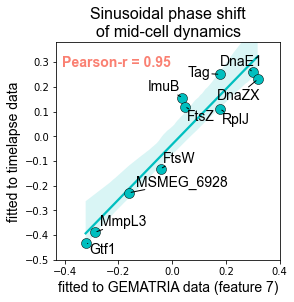

In [256]:
import adjustText
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot()
plt.xlim(-0.43,0.4)
plt.ylim(-0.5,0.38)
x,y = fit_stat['GEM_P'].values.astype(float), fit_stat['TL_P'].values.astype(float)
ax.scatter(x,y,fc='c',ec='black',s=100,lw=0.5,zorder=3)
#ax.vlines(x, y-fit_stat['TL_perV_P'].values.astype(float),
#          y+fit_stat['TL_perV_P'].values.astype(float),color='black')
#ax.hlines(y,x-fit_stat['GEM_perV_P'].values.astype(float),
#          x+fit_stat['GEM_perV_P'].values.astype(float),color='black')
labels = []
for i,n in enumerate(fit_stat['name'].values):
    labels.append(ax.text(x[i],y[i],n,fontsize=14,ha='left',fontname='Arial'))
adjustText.adjust_text(labels,arrowprops=dict(arrowstyle='-', color='black'),
                       force_points=(0.5,1),
                       force_text=(0.9,1),
                       expand_points=(1.3,1.5))
sns.regplot(x,y,color='c')
ax.set_title('Sinusoidal phase shift\nof mid-cell dynamics', fontsize=16,fontname='Arial')
ax.set_xlabel('fitted to GEMATRIA data (feature 7)',fontsize=14,fontname='Arial')
ax.set_ylabel('fitted to timelapse data',fontsize=14,fontname='Arial')
r,p = stats.pearsonr(x,y)
ax.text(-0.41,0.28,'Pearson-r = {}'.format(round(r,2)), fontsize=14,fontname='Arial',
        color='salmon',weight='bold')
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/timelapse/correlation.png',dpi=120,bbox_inches='tight')

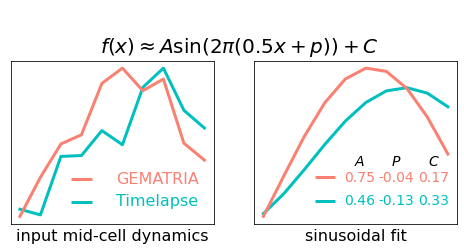

In [558]:
# schematic of sinusoidal fit:
#
fit_gem = fit_stat.iloc[np.where(fit_stat['locus']=='MSMEG_4228')[0]][['GEM_A','GEM_P','GEM_C']].values[0].astype(float)
fit_tl = fit_stat.iloc[np.where(fit_stat['locus']=='MSMEG_4228')[0]][['TL_A','TL_P','TL_C']].values[0].astype(float)
fig = plt.figure(figsize=(8,4))
grids = gs(4,11,hspace=0,wspace=0)
ax1= fig.add_subplot(grids[0,:])
ax2= fig.add_subplot(grids[1:,:5])
ax3=fig.add_subplot(grids[1:,6:])
ax1.axis('off')
ax1.annotate(r"$f(x) \approx A{\rm sin}(2\pi (0.5x + p)) +C$",xy=(0.2,0.15),fontname='Arial',fontsize=20)
ax1.set_xlim(0,1)
#ax1.annotate(r"$A$:{}, $p$:{}, $C$:{}".format(round(A,2),round(P,2),round(C,2)),xy=(0,0.5),fontsize=16)
ax3.set_yticks([])

tl = raw_data[raw_data['locus']=='MSMEG_4228'][['TL_raw_{}'.format(x) for x in np.arange(1,11)]].values.astype(float)[0]
gem = raw_data[raw_data['locus']=='MSMEG_4228'][['GEM_raw_{}'.format(x) for x in np.arange(1,11)]].values.astype(float)[0]
tl_fitted = fit_stat[fit_stat['locus']=='MSMEG_4228'][['fitted_timelapse_{}'.format(x) for x in np.arange(1,11)]].values.astype(float)[0]
gem_fitted = fit_stat[fit_stat['locus']=='MSMEG_4228'][['fitted_gem_{}'.format(x+1) for x in range(10)]].values.astype(float)[0]
ax2.plot(tl,color='c',lw=3)
ax2.plot(gem,color='salmon',lw=3)
ax3.plot(tl_fitted,color='c',lw=3,ls='-')
ax3.plot(gem_fitted,color='salmon',lw=3, ls='-')
for i,x in enumerate([4.7,6.5,8.3]):
    ax3.text(x,0.3,'${}$'.format(['A','P','C'][i]),ha='center',fontsize=14)
    ax3.text(x,0.2,round(fit_gem[i],2),ha='center',fontsize=14,color='salmon')
    ax3.text(x,0.05,round(fit_tl[i],2),ha='center',fontsize=14,color='c')
ax3.hlines(0.225,2.5,3.5,color='salmon',lw=3)
ax3.hlines(0.075,2.5,3.5,color='c',lw=3)
ax2.set_xticks([])
ax3.set_xticks([])
ax2.set_yticks([])
ax2.hlines(0.25,2.5,3.5,color='salmon',lw=3)
ax2.hlines(0.1,2.5,3.5,color='c',lw=3)
ax2.text(4.7,0.225,'GEMATRIA',fontsize=16,color='salmon',ha='left')
ax2.text(4.7,0.075,'Timelapse',ha='left',fontsize=16,color='c')
ax2.set_xlabel('input mid-cell dynamics',ha='center',fontsize=16)
ax3.set_xlabel('sinusoidal fit',ha='center',fontsize=16)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/timelapse/fit.png',dpi=120,bbox_inches='tight')

In [301]:
raw_data[raw_data['locus']=='MSMEG_4228'][['TL_raw_{}'.format(x) for x in np.arange(1,11)]].values.astype(float)

array([[0.04810198, 0.00990099, 0.40459365, 0.41028256, 0.57858452,
        0.48335357, 0.87057881, 1.        , 0.71574969, 0.59607115]])

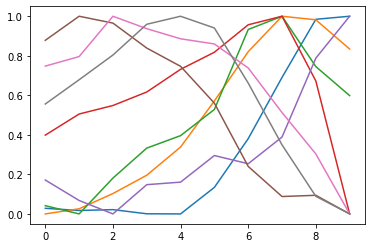

In [74]:
key='MSMEG_0250'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))
key='MSMEG_6928'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))
key='MSMEG_4228'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))
key='MSMEG_4222'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))
key='MSMEG_4479'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))
key='MSMEG_3178'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))
#plt.plot(normalize1d(reshaped[np.where(df['locus'].values == key)][0,:,6]))
key='MSMEG_5082'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))
#plt.plot(normalize1d(reshaped[np.where(df['locus'].values == key)][0,:,6]))
key='MSMEG_1622'
strain_dict,averaged=length_normalized_dynamics(merge_tl_data('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key)),normalize=True,flip=False)
averaged = [mean_norm(x) for x in averaged]
plt.plot(normalize1d(np.mean(gaussian(np.mean(averaged,axis=0),sigma=0.5)[:,12:16],axis=1)))

In [333]:
def xydrift_correction(target_img, shift, max_drift=1000):
    if max(np.abs(shift)) <= max_drift:
        return shift_image(target_img, np.array(shift))
    else:
        return target_img
    
def get_xydrift(ref_img, target_img):
    from skimage import registration
    shift, error, _diff = registration.phase_cross_correlation(ref_img, target_img, upsample_factor=10)
    return shift

def shift_image(img, shift):
    from scipy import ndimage as ndi
    """
    correct xy drift between phase contrast image and fluorescent image(s)
    :param img: input image
    :param shift: subpixel xy drift
    :return: drift corrected image
    """
    offset_image = ndi.fourier_shift(np.fft.fftn(img), shift)
    offset_image = np.fft.ifftn(offset_image)
    offset_image = np.round(offset_image.real)
    offset_image[offset_image <= 0] = 10
    # rescaled to avoid int16 overflow
    offset_image[offset_image>=65530] = 65530
    return offset_image.astype(np.uint16)

In [14]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_1364/movie.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_1364/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [14]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4479/S4.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4479/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [15]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4479/S2.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4479/movie_driftcorrected2.tif',drift_corrected.astype(np.uint16),imagej=True)

In [17]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4263/movie.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4263/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [334]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_0250/movie.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_0250/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [337]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_1622/movie.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_1622/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [339]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_6285/movie.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_6285/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [340]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_6928/movie.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_6928/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [338]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_3178/29-2.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_3178/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [341]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4228/24-1.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4228/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [ ]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4228/24-1.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_4228/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [343]:
images = tifffile.imread('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_0389/movie.tif')
drift_corrected = np.zeros(images.shape)
last_drift = np.array([0,0])
for i in range(len(images)):
    if i==0:
        drift_corrected[i] = images[i]
    if i!=0:
        last_drift = last_drift+get_xydrift(images[i-1,1],images[i,1])
        drift_corrected[i,0] = xydrift_correction(images[i][0],last_drift)
        drift_corrected[i,1] = xydrift_correction(images[i][1],last_drift)
tifffile.imsave('/Volumes/Extreme_SSD/MSR_Timelapse/MSMEG_0389/movie_driftcorrected.tif',drift_corrected.astype(np.uint16),imagej=True)

In [699]:
def unit_kymograph(tl_excel,xpixels = 100):
    raw_d = pd.read_excel(tl_excel,header=None).values
    data_dict = {}
    n=100
    max_l = 0
    for i in np.arange(0,raw_d.shape[1],2):
        x=raw_d[:,i][np.isnan(raw_d[:,i])==0]
        y=raw_d[:,i+1][np.isnan(raw_d[:,i+1])==0]
        l=x.max()
        data_dict[int(i/2)]=[l,x,y]
        max_l = max(l,max_l)
    tiles = []
    norm_data = []
    for i,v in data_dict.items():
        l,x,y = v
        d = np.zeros(xpixels)
        if l>max_l:
            tiles.append(np.interp(np.linspace(0,1,xpixels),xp=x/x.max(),fp=y))
        else:
            half_l = int(round(0.5*l*xpixels/max_l))
            pad = int((xpixels-half_l*2)/2)
            tiles.append(np.array([0]*pad+list(np.interp(np.linspace(0,1,half_l*2),xp=x/x.max(),fp=y))+[0]*pad))    
    return tiles,data_dict

def unit_kymograph_alignment(excel,xpixels=100):
    tiles, data_dict = unit_kymograph(excel, xpixels=xpixels)
    newtiles = [tiles[-1]]
    a = tiles[-1]
    for i in range(len(tiles)-2,-1,-1):
        b = tiles[i]
        corr = []
        rolled = []
        for i in range(-1,1):
            newb = np.roll(b,i)
            corr.append(stats.pearsonr(a,newb)[0])
            rolled.append(i)
        nroll = rolled[np.argmax(corr)]
        a = np.roll(b,nroll)
        newtiles.append(a)
    return np.flip(np.array(newtiles),axis=0)

def kymograph(folder,normalize=False,flip=False,shape=(15,50)):
    from skimage.transform import resize
    
    kymographs = []
    for f in sorted(glob.glob(folder+'*.xlsx')):
        header = f.split('/')[-1].split('.')[0]
        aligned = unit_kymograph_alignment(f,xpixels=shape[1])
        reshaped = resize(aligned,shape,anti_aliasing=True)
        if normalize:
            reshaped = mean_norm(reshaped)
        if flip:
            reshaped = np.flip(reshaped,axis=1)
        kymographs.append(reshaped) 
    return np.array(kymographs)



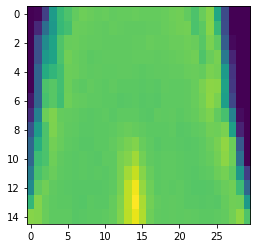

In [700]:
# MSMEG_4263 kymograph
key='MSMEG_0250'
kymographs = kymograph('/Volumes/Extreme_SSD/MSR_Timelapse/{}/'.format(key),normalize=False,shape=(15,30),flip=False)
fig=plt.figure(figsize=(4,4))
#plt.imshow(gaussian(np.mean(kymographs,axis=0),sigma=0.5),aspect='auto')
plt.imshow(gaussian(np.mean(kymographs,axis=0),sigma=0.1),aspect='auto')

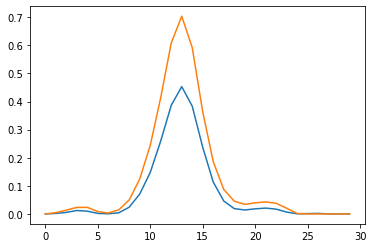

In [423]:
plt.plot(np.mean(h[6].reshape(15,30),axis=0))
plt.plot(h[6].reshape(15,30)[7])

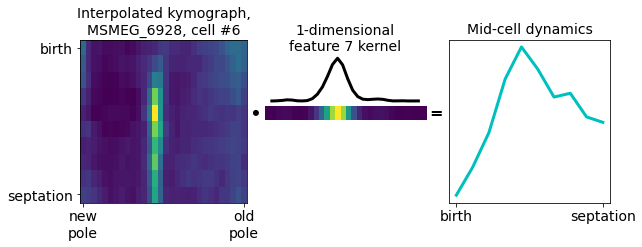

In [533]:
fig=plt.figure(figsize=(9.5,3))
n=6
grids = gs(10,95)
ax1 = fig.add_subplot(grids[:,:30])
ax1.imshow(averaged[n],aspect='auto')
ax2 = fig.add_subplot(grids[:,31:33])
ax2.scatter(0.25,0.55,fc='black',ec='None')
ax2.set_ylim(0,1)
ax2.set_xlim(0,1)
ax2.axis('off')
ax3 = fig.add_subplot(grids[4,33:62])
ax3.imshow(np.mean(h[6].reshape(15,30),axis=0).reshape(1,-1),aspect='auto')
ax3.axis('off')
ax4 = fig.add_subplot(grids[1:4,33:62])
ax4.axis('off')
ax4.plot(np.mean(h[6].reshape(15,30),axis=0),color='black',lw=3)
ax4.set_title('1-dimensional\nfeature 7 kernel',fontsize=14)
ax5 = fig.add_subplot(grids[:,62:64])
ax5.axis('off')
ax5.set_ylim(0,1)
ax5.set_xlim(0,1)
ax5.text(0.25,0.55,'=',fontsize=16,va='center',fontweight='bold',ha='left')
ax6 = fig.add_subplot(grids[:,66:])
ax6.set_xticks([0,9])
ax6.set_yticks([])
ax6.plot(averaged[n].dot(np.mean(h[6].reshape(15,30),axis=0)),color='c',lw=3)
ax1.set_title('Interpolated kymograph,\nMSMEG_6928, cell #{}'.format(n),fontsize=14)
ax1.set_yticks([0,9])
ax1.set_xticks([0,29])
ax1.set_xticklabels(['new\npole','old\npole'],fontsize=14)
ax1.set_yticklabels(['birth','septation'],fontsize=14)
ax6.set_xticklabels(['birth','septation'],fontsize=14)
ax6.set_title('Mid-cell dynamics',fontsize=14)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/timelapse/convolution.png',dpi=120,bbox_inches='tight')

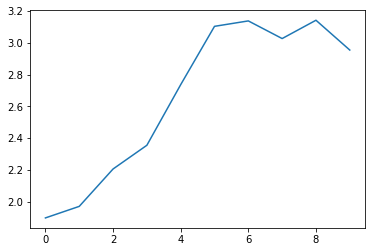

In [430]:
plt.plot(averaged[0].dot(np.mean(h[6].reshape(15,30),axis=0)))